# Enrollment status prediction

The objective is to predict the enrollments status of students after the normal duration of their course. This can therefore be formulated as a three class classification problem.

## Setting things up

### Importing libraries

In [3]:
#import libraries

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

from sklearn.model_selection import StratifiedShuffleSplit, cross_validate, GridSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score

from sklearn import set_config

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as imbpipeline

### Loading the data

In [4]:
train = pd.read_csv("./../data/2_final/train.csv")
test =  pd.read_csv("./../data/2_final/test.csv")

## Preprocessing the data

These are the avalible features

In [5]:
train.columns

Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Attendance_mode', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)'

Since the initial analysis shows that most of the students who dropout do so in the first two semesters, it doesn't make sense to use features that are not available at the time of enrollment. Let us also drop the features that are reduntant.

In [6]:
features_to_include = ['Marital status', 'Application mode', 'Application order', 'Course',
       'Attendance_mode', 'Previous qualification (grade)', 'Admission grade', 'Displaced', 
       'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International', 'father_occ', 'mother_occ', 'father_qual', 'mother_qual', 'previous_qual',
        'Target']

Selecting required columns,

In [7]:
train_df = train[features_to_include]
test_df = test[features_to_include]

Seperating features and label

In [8]:
y_train = train_df["Target"]
X_train = train_df.drop("Target", axis=1)

y_test = test_df["Target"]
X_test = test_df.drop("Target", axis=1)

The features can be grouped into categorical, ordinal and numerical types.

In [9]:
cat_features = ['Course', 'previous_qual', 'Debtor', 'Gender', 'Scholarship holder', 'father_occ', 'mother_occ', 'father_qual', 'mother_qual', 'Marital status', 'Application mode', 'Attendance_mode', 'International', 'Displaced']
num_features = ['Previous qualification (grade)', 'Admission grade', 'Age at enrollment']
ordinal_features = ['Application order']

Building pipelines for feature encodings and transformations and recombine them into a single feature matrix

In [10]:
select_cat_features = ColumnTransformer([('select_cat', 'passthrough', cat_features)])
cat_transformers = Pipeline([('selector', select_cat_features),
                            ('onehot', OneHotEncoder(handle_unknown='ignore')),
                            ])

select_ord_features = ColumnTransformer([('select_cat', 'passthrough', ordinal_features)])
ordinal_transformers = Pipeline([('selector', select_ord_features),
                            ('ordinal_enc', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
                            ])
                            
select_num_features = ColumnTransformer([('select_num', 'passthrough', num_features)])
num_transformers = Pipeline([('selector', select_num_features),
                            ('scaler', StandardScaler()),
                            ])

preprocess_pipe = FeatureUnion([('cat', cat_transformers),
                                ('ord', ordinal_transformers),
                                ('num', num_transformers),
                                ])

In [11]:
set_config(display="diagram")
preprocess_pipe

FeatureUnion(transformer_list=[('cat',
                                Pipeline(steps=[('selector',
                                                 ColumnTransformer(transformers=[('select_cat',
                                                                                  'passthrough',
                                                                                  ['Course',
                                                                                   'previous_qual',
                                                                                   'Debtor',
                                                                                   'Gender',
                                                                                   'Scholarship '
                                                                                   'holder',
                                                                                   'father_occ',
                                                                                   'mother_occ',
                                                                                   'father_qual',
                                                                                   'mother_qual',
                                                                                   'Marital '
                                                                                   'status',
                                                                                   'Application '
                                                                                   'mode',
                                                                                   'Attendance_mode',
                                                                                   'International',
                                                                                   'Displaced'])])),
                                                ('onehot',
                                                 OneHo...
                                                 ColumnTransformer(transformers=[('select_cat',
                                                                                  'passthrough',
                                                                                  ['Application '
                                                                                   'order'])])),
                                                ('ordinal_enc',
                                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                unknown_value=-1))])),
                               ('num',
                                Pipeline(steps=[('selector',
                                                 ColumnTransformer(transformers=[('select_num',
                                                                                  'passthrough',
                                                                                  ['Previous '
                                                                                   'qualification '
                                                                                   '(grade)',
                                                                                   'Admission '
                                                                                   'grade',
                                                                                   'Age '
                                                                                   'at '
                                                                                   'enrollment'])])),
                                                ('scaler',
                                                 StandardScaler())]))])

## Modelling

Let's start the modelling process. First we will write a `Model` class to abstract repetitive tasks.

In [12]:
class Model:
    def __init__(self, model_name, estimator, preprocessor=None, scoring=None, cv=5, random_state=42):
        self.name = model_name
        self.estimator = estimator
        self.preprocess = preprocessor
        self.scoring = scoring
        self.cv = cv
        self.rs = random_state

    def make_model_pipeline(self):
        self.model = Pipeline([('preprocess', self.preprocess),
                                ('model', self.estimator)])
        

    def train(self, X_train, y_train):
        '''Trains the  model
        Args:
            X_train: Training data feature matrix
            y_train: Training data label vector
            
        Returns:
            trained model
        '''
        self.make_model_pipeline()

        
        self.cv_results = cross_validate(self.model, X_train, y_train, cv=self.cv, scoring=self.scoring, return_train_score=True)

        mean_train_score = self.cv_results["train_score"].mean()
        mean_val_score = self.cv_results["test_score"].mean()
        
        std_train_score = self.cv_results["train_score"].std()
        std_val_score = self.cv_results["test_score"].std()

        print(f"Cross validated training results for {self.name} model")
        print("---------------------------------------------------------")
        print(f"Train score: {mean_train_score} +/- {std_train_score}" )
        print(f"Validation score: {mean_val_score} +/- {std_val_score}" )

        self.fitted_model = self.model.fit(X_train, y_train)

    def evaluate(self, X_test, y_test):
        y_pred = self.fitted_model.predict(X_test)

        f1 = f1_score(y_test, y_pred, average="micro")
        print("F1 score on test set: ", f1)
        print()
        print(classification_report(y_test, y_pred))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    
    def tune(self, param_grid, X_train, y_train):
        '''Do hyper parameter tuning using GridSearch strategy
        
        Args:
            model: Model to be tuned
            param_grid: dict of parameters
            X_train: Feature matrix
            y_train: Label matrix
            
        Returns: 
            best parameters
            best estimator
        '''

        self.make_model_pipeline()
        search = GridSearchCV(self.model, param_grid = param_grid,
                            cv = self.cv,
                            scoring=self.scoring,
                            return_train_score=True)
        
        search.fit(X_train, y_train)
        
        print("Best parameters: ", search.best_params_)
        
        print("-------------------Best model performance --------------------------")
        
        mean_train_score = search.cv_results_['mean_train_score'][search.best_index_]
        mean_val_score = search.cv_results_['mean_test_score'][search.best_index_]
        std_train_score = search.cv_results_['std_train_score'][search.best_index_]
        std_val_score = search.cv_results_['std_test_score'][search.best_index_]

        print(f"Score of the model on the train set:\n"
            f"{mean_train_score:.3f} +/- {std_train_score:.6f}")

        print(f"Score of the model on the validation set:\n"
            f"{mean_val_score:.3f} +/- {std_val_score:.6f}")
        
        self.fitted_model = search.best_estimator_

In [13]:
##Let's supress sklearn warnings

def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

In [14]:
## Cross validation scheme

cv = StratifiedShuffleSplit(n_splits = 5, test_size=0.2, random_state=32)

### Baseline model

In [146]:
baseline_clf = Model(model_name="Baseline classifier", 
                    estimator=DummyClassifier(),
                    preprocessor=preprocess_pipe,
                    scoring="f1_micro",
                    cv = cv,
                    random_state=32)

In [147]:
baseline_clf.train(X_train, y_train)

Cross validated training results for Baseline classifier model
---------------------------------------------------------
Train score: 0.49911691981631934 +/- 0.0
Validation score: 0.5 +/- 0.0


F1 score on test set:  0.4994350282485876

              precision    recall  f1-score   support

     Dropout       0.00      0.00      0.00       284
    Enrolled       0.00      0.00      0.00       159
    Graduate       0.50      1.00      0.67       442

    accuracy                           0.50       885
   macro avg       0.17      0.33      0.22       885
weighted avg       0.25      0.50      0.33       885



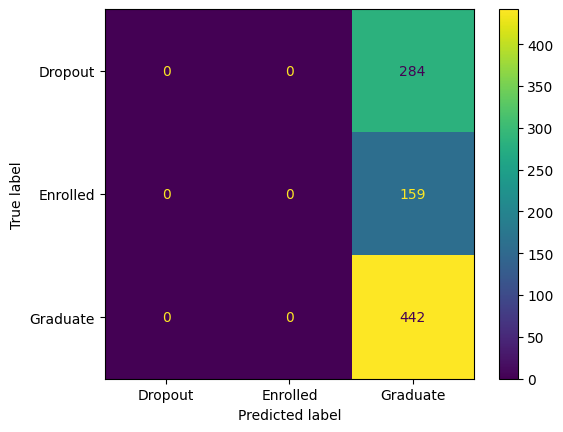

In [148]:
baseline_clf.evaluate(X_test, y_test)

### Logistic Regression

In [149]:
logistic_clf = Model(model_name="Logistic Regression", 
                    estimator=LogisticRegression(penalty = "elasticnet", solver="saga", l1_ratio=0,  max_iter=1000),
                    preprocessor=preprocess_pipe,
                    scoring="f1_micro",
                    cv = cv,
                    random_state=32)

In [150]:
logistic_clf.train(X_train, y_train)

Cross validated training results for Logistic Regression model
---------------------------------------------------------
Train score: 0.6564464853408689 +/- 0.005728897190452344
Validation score: 0.6322033898305085 +/- 0.015384461925638535


In [151]:
param_grid = {"model__C": [0.01, 0.1, 1, 10, 100],
            "model__l1_ratio": np.linspace(0, 1, 11)}
logistic_clf.tune(param_grid, X_train, y_train)

Best parameters:  {'model__C': 1, 'model__l1_ratio': 0.8}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.655 +/- 0.006469
Score of the model on the validation set:
0.636 +/- 0.012117


F1 score on test set:  0.5966101694915255

              precision    recall  f1-score   support

     Dropout       0.58      0.58      0.58       284
    Enrolled       0.32      0.11      0.17       159
    Graduate       0.64      0.78      0.70       442

    accuracy                           0.60       885
   macro avg       0.51      0.49      0.48       885
weighted avg       0.56      0.60      0.57       885



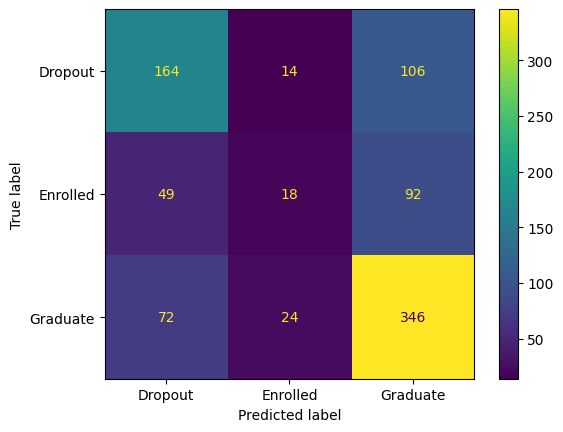

In [152]:
logistic_clf.evaluate(X_test, y_test)

### Ridge classifier

In [158]:
ridge_clf = Model(model_name = "Ridge classifier", 
                    estimator = RidgeClassifier(),
                    preprocessor = preprocess_pipe,
                    scoring = "f1_micro",
                    random_state = 32)

In [159]:
ridge_clf.train(X_train, y_train)

Cross validated training results for Ridge classifier model
---------------------------------------------------------
Train score: 0.6530094324937585 +/- 0.004686394803950536
Validation score: 0.626166103293138 +/- 0.007790679854288551


In [160]:
param_grid = {"model__alpha": [0.01, 0.1, 1, 10, 100]}
ridge_clf.tune(param_grid, X_train, y_train)

Best parameters:  {'model__alpha': 10}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.651 +/- 0.003160
Score of the model on the validation set:
0.628 +/- 0.008617


F1 score on test set:  0.6045197740112994

              precision    recall  f1-score   support

     Dropout       0.57      0.60      0.58       284
    Enrolled       0.23      0.03      0.06       159
    Graduate       0.64      0.82      0.71       442

    accuracy                           0.60       885
   macro avg       0.48      0.48      0.45       885
weighted avg       0.54      0.60      0.55       885



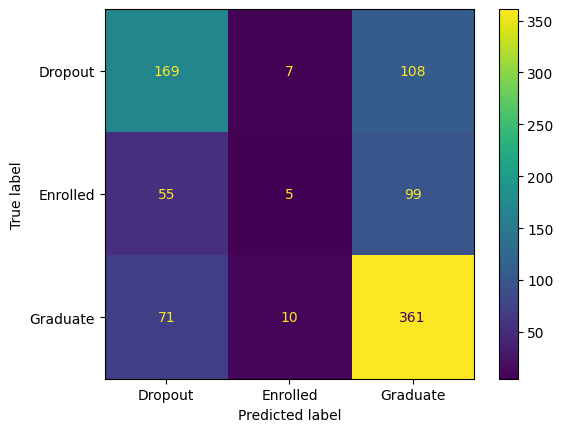

In [161]:
ridge_clf.evaluate(X_test, y_test)

### Support vector machine

In [162]:
svm_clf = Model(model_name = "SVM classifier", 
                    estimator = LinearSVC(),
                    preprocessor = preprocess_pipe,
                    scoring = "f1_micro",
                    random_state = 32)

In [163]:
svm_clf.train(X_train, y_train)

Cross validated training results for SVM classifier model
---------------------------------------------------------
Train score: 0.6530799292338456 +/- 0.0049647075149790625
Validation score: 0.6241883026075004 +/- 0.0066434622082158406


In [164]:
param_grid = {"model__penalty": ["l1", "l2"],
                "model__loss": ["hinge", "squared_hinge"],
                "model__C": [0.001, 0.01, 0.1, 1, 10, 100]}
svm_clf.tune(param_grid, X_train, y_train)

Best parameters:  {'model__C': 10, 'model__loss': 'hinge', 'model__penalty': 'l2'}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.647 +/- 0.006423
Score of the model on the validation set:
0.628 +/- 0.013684


F1 score on test set:  0.5977401129943503

              precision    recall  f1-score   support

     Dropout       0.57      0.59      0.58       284
    Enrolled       0.11      0.01      0.01       159
    Graduate       0.62      0.81      0.70       442

    accuracy                           0.60       885
   macro avg       0.43      0.47      0.43       885
weighted avg       0.51      0.60      0.54       885



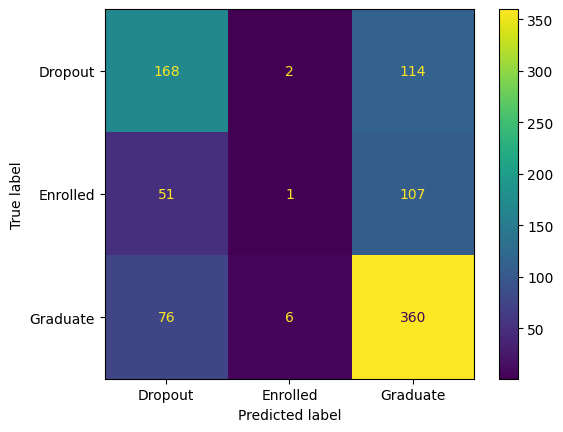

In [165]:
svm_clf.evaluate(X_test, y_test)

### Decision tree 

In [23]:
tree_clf = Model(model_name = "Decision tree classifier", 
                    estimator = DecisionTreeClassifier(),
                    preprocessor = preprocess_pipe,
                    scoring = "f1_micro",
                    random_state = 32)

In [24]:
tree_clf.train(X_train, y_train)

Cross validated training results for Decision tree classifier model
---------------------------------------------------------
Train score: 1.0 +/- 0.0
Validation score: 0.5080502481240861 +/- 0.01208152420239605


In [25]:
param_grid = {"model__max_depth": [2, 3, 4, 5, 10],
                "model__min_samples_split":[2, 4, 6, 8, 10],
                "model__min_samples_leaf": [1, 2, 3, 6, 7, 8]}

tree_clf.tune(param_grid, X_train, y_train)

Best parameters:  {'model__max_depth': 4, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.609 +/- 0.006163
Score of the model on the validation set:
0.592 +/- 0.013576


F1 score on test set:  0.584180790960452

              precision    recall  f1-score   support

     Dropout       0.55      0.54      0.54       284
    Enrolled       0.00      0.00      0.00       159
    Graduate       0.60      0.83      0.70       442

    accuracy                           0.58       885
   macro avg       0.38      0.45      0.41       885
weighted avg       0.48      0.58      0.52       885



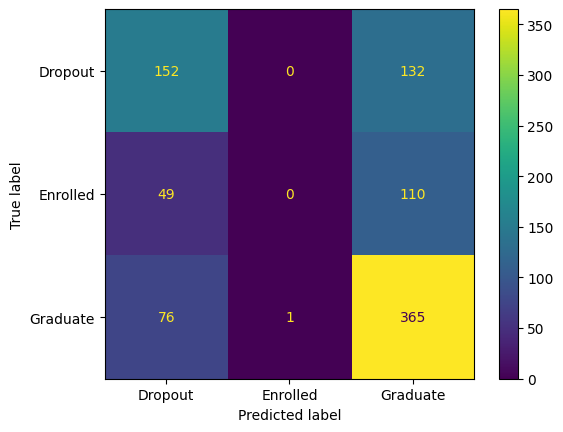

In [26]:
tree_clf.evaluate(X_test, y_test)

### Random Forest

In [27]:
rf_clf = Model(model_name = "Random forest classifier", 
                    estimator = RandomForestClassifier(),
                    preprocessor = preprocess_pipe,
                    scoring = "f1_micro",
                    random_state = 32)

In [28]:
rf_clf.train(X_train, y_train)

Cross validated training results for Random forest classifier model
---------------------------------------------------------
Train score: 1.0 +/- 0.0
Validation score: 0.6094958406252248 +/- 0.020310840909066975


In [29]:
param_grid = {"model__n_estimators": [125, 150, 175],
                "model__max_depth": [3, 4, 5, 10, 15],
                "model__min_samples_split":[2, 4, 6, 8, 10],
                "model__min_samples_leaf": [1, 2, 3, 6, 7, 8]}

rf_clf.tune(param_grid, X_train, y_train)

Best parameters:  {'model__max_depth': 15, 'model__min_samples_leaf': 2, 'model__min_samples_split': 4, 'model__n_estimators': 150}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.804 +/- 0.006742
Score of the model on the validation set:
0.626 +/- 0.019775


F1 score on test set:  0.6011299435028249

              precision    recall  f1-score   support

     Dropout       0.56      0.60      0.58       284
    Enrolled       0.40      0.04      0.07       159
    Graduate       0.63      0.81      0.71       442

    accuracy                           0.60       885
   macro avg       0.53      0.48      0.45       885
weighted avg       0.57      0.60      0.55       885



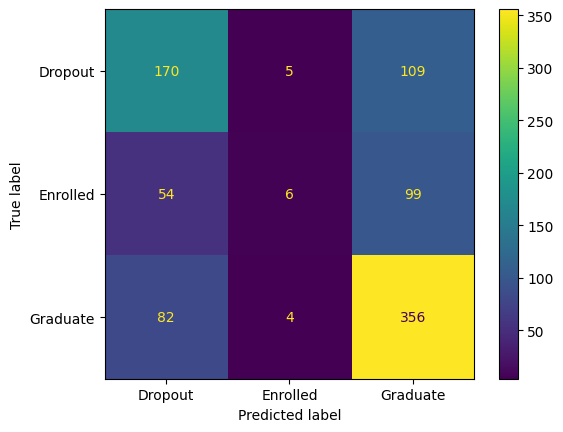

In [30]:
rf_clf.evaluate(X_test, y_test)

### Gradient boosting

In [185]:
gboost_clf = Model(model_name = "Gradient boosting classifier", 
                    estimator = GradientBoostingClassifier(),
                    preprocessor = preprocess_pipe,
                    scoring = "f1_micro",
                    random_state = 32)

In [186]:
gboost_clf.train(X_train, y_train)

Cross validated training results for Gradient boosting classifier model
---------------------------------------------------------
Train score: 0.7092402117795912 +/- 0.0031566880299609243
Validation score: 0.6315365313771086 +/- 0.011829383939479373


In [187]:
param_grid = {"model__n_estimators": [50, 100, 150, 200]}

gboost_clf.tune(param_grid, X_train, y_train)

Best parameters:  {'model__n_estimators': 100}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.710 +/- 0.003644
Score of the model on the validation set:
0.633 +/- 0.012984


F1 score on test set:  0.607909604519774

              precision    recall  f1-score   support

     Dropout       0.57      0.60      0.58       284
    Enrolled       0.34      0.08      0.13       159
    Graduate       0.65      0.81      0.72       442

    accuracy                           0.61       885
   macro avg       0.52      0.49      0.48       885
weighted avg       0.57      0.61      0.57       885



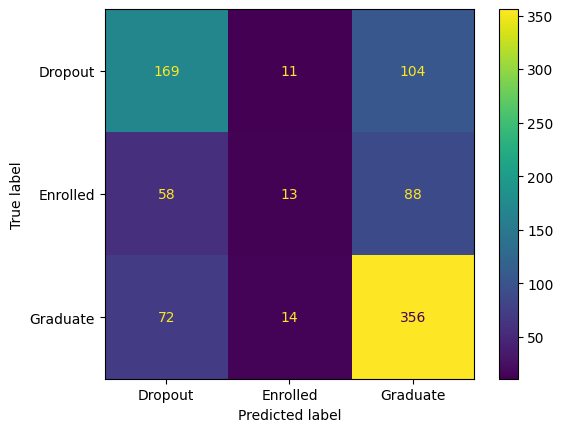

In [188]:
gboost_clf.evaluate(X_test, y_test)

### XGBoost

In [15]:
xgb_clf = Model(model_name = "XGBoost classifier", 
                estimator = XGBClassifier(),
                preprocessor = preprocess_pipe,
                scoring = "f1_micro",
                random_state = 32)

In [17]:
target_map = {"Graduate": 0,
                "Enrolled": 1,
                "Dropout": 2}

y_train_enc = y_train.map(target_map)
y_test_enc = y_test.map(target_map)

In [19]:
xgb_clf.train(X_train, y_train_enc)

Cross validated training results for XGBoost classifier model
---------------------------------------------------------
Train score: 0.9555666730527832 +/- 0.0027647970514426447
Validation score: 0.6007403767011084 +/- 0.013551171808362125


In [22]:
param_grid = {"model__n_estimators": [25, 50, 75, 100, 150, 200],
                "model__max_depth": [5, 10, 15, 20]}

xgb_clf.tune(param_grid, X_train, y_train_enc)

Best parameters:  {'model__max_depth': 5, 'model__n_estimators': 25}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.743 +/- 0.004894
Score of the model on the validation set:
0.624 +/- 0.010983


F1 score on test set:  0.5954802259887005

              precision    recall  f1-score   support

           0       0.65      0.78      0.71       442
           1       0.28      0.09      0.14       159
           2       0.56      0.59      0.57       284

    accuracy                           0.60       885
   macro avg       0.49      0.49      0.47       885
weighted avg       0.55      0.60      0.56       885



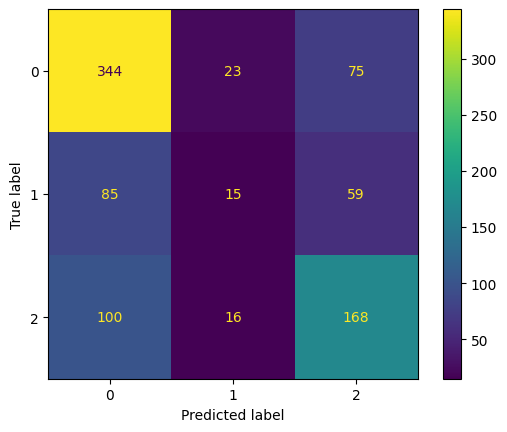

In [21]:
xgb_clf.evaluate(X_test, y_test_enc)